In [12]:
import pandas_datareader as pdr

In [16]:
with open('api_key.txt') as file:
    api_key = file.readline()


In [20]:
df = pdr.get_data_tiingo('AAPL',api_key=api_key)

In [21]:
df.to_csv('AAPL.csv')

In [22]:
import pandas as pd

In [23]:
df = pd.read_csv('AAPL.csv')

In [24]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-05-24 00:00:00+00:00,97.90,98.09,96.840,97.22,35140174,22.860967,22.905334,22.613442,22.702177,140560696,0.0,1.0
1,AAPL,2016-05-25 00:00:00+00:00,99.62,99.74,98.110,98.67,38642108,23.262610,23.290631,22.910004,23.040772,154568432,0.0,1.0
2,AAPL,2016-05-26 00:00:00+00:00,100.41,100.73,98.640,99.68,56331159,23.447085,23.521810,23.033766,23.276620,225324636,0.0,1.0
3,AAPL,2016-05-27 00:00:00+00:00,100.35,100.47,99.245,99.44,36341240,23.433074,23.461096,23.175042,23.220577,145364960,0.0,1.0
4,AAPL,2016-05-31 00:00:00+00:00,99.86,100.40,98.820,99.60,42307212,23.318653,23.444750,23.075799,23.257939,169228848,0.0,1.0


In [25]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2021-05-17 00:00:00+00:00,126.27,126.930,125.17,126.82,74244624,126.27,126.930,125.17,126.82,74244624,0.0,1.0
1254,AAPL,2021-05-18 00:00:00+00:00,124.85,126.990,124.78,126.56,63342929,124.85,126.990,124.78,126.56,63342929,0.0,1.0
1255,AAPL,2021-05-19 00:00:00+00:00,124.69,124.915,122.86,123.16,92611989,124.69,124.915,122.86,123.16,92611989,0.0,1.0
1256,AAPL,2021-05-20 00:00:00+00:00,127.31,127.720,125.10,125.23,76857123,127.31,127.720,125.10,125.23,76857123,0.0,1.0
1257,AAPL,2021-05-21 00:00:00+00:00,125.43,128.000,125.21,127.82,79295436,125.43,128.000,125.21,127.82,79295436,0.0,1.0


In [29]:
df2 = df.reset_index()['close']

In [34]:
df2.head()

0     97.90
1     99.62
2    100.41
3    100.35
4     99.86
Name: close, dtype: float64

In [35]:
df2.shape

(1258,)

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:ylabel='close'>

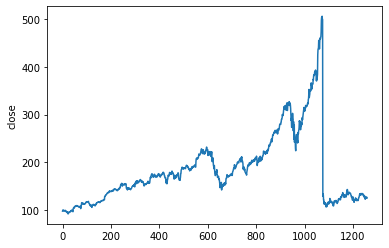

In [33]:
sns.lineplot(data=df2)

In [36]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [39]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df2).reshape(-1,1))

In [40]:
df1

array([[0.01415288],
       [0.01830697],
       [0.02021495],
       ...,
       [0.07885521],
       [0.08518295],
       [0.08064243]])

In [69]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [73]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [74]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [75]:
X_train.shape

(716, 100)

In [76]:
y_train.shape

(716,)

In [77]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [78]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [79]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Train on 716 samples, validate on 340 samples
Epoch 1/100
716/716 [==============================] - 12s 17ms/sample - loss: 0.0092 - val_loss: 0.0436
Epoch 2/100
716/716 [==============================] - 3s 4ms/sample - loss: 0.0023 - val_loss: 0.0246
Epoch 3/100
716/716 [==============================] - 2s 3ms/sample - loss: 0.0012 - val_loss: 0.0242
Epoch 4/100
716/716 [==============================] - 2s 3ms/sample - loss: 5.9177e-04 - val_loss: 0.0198
Epoch 5/100
716/716 [==============================] - 3s 4ms/sample - loss: 4.1713e-04 - val_loss: 0.0197
Epoch 6/100
716/716 [==============================] - 2s 3ms/sample - loss: 4.1236e-04 - val_loss: 0.0187
Epoch 7/100
716/716 [==============================] - 2s 3ms/sample - loss: 4.0998e-04 - val_loss: 0.0182
Epoch 8/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.7571e-04 - val_loss: 0.0179
Epoch 9/100
716/716 [==============================] - 2s 3ms/sample - loss: 3.5923e-04 - val_loss: 0.0176
E

716/716 [==============================] - 2s 3ms/sample - loss: 1.4774e-04 - val_loss: 0.0106
Epoch 77/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.3989e-04 - val_loss: 0.0134
Epoch 78/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.5009e-04 - val_loss: 0.0103
Epoch 79/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.4224e-04 - val_loss: 0.0136
Epoch 80/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.5472e-04 - val_loss: 0.0090
Epoch 81/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.3665e-04 - val_loss: 0.0107
Epoch 82/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.9058e-04 - val_loss: 0.0080
Epoch 83/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.4418e-04 - val_loss: 0.0105
Epoch 84/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.3467e-04 - val_loss: 0.0120
Epoch 85/100
716/716 [===================

In [82]:
import tensorflow as tf

In [83]:
tf.__version__

'2.1.0'

In [84]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [85]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [86]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

168.24660529965962

In [87]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

244.30407204487

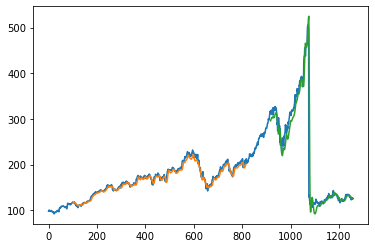

In [88]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [89]:
len(test_data)

441

In [90]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [91]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [92]:
temp_input

[0.10344161333172322,
 0.10066417099384131,
 0.09817654872599926,
 0.09025480014491002,
 0.09411906774544135,
 0.08346818017147686,
 0.09390170269291145,
 0.09663084168578676,
 0.08921627822726722,
 0.08878154812220748,
 0.09382924767540149,
 0.08904721651974398,
 0.08477237048665617,
 0.08643883588938531,
 0.0965825383407801,
 0.10827194783238739,
 0.11358531578311795,
 0.12288370969689646,
 0.12346334983697618,
 0.1208066658616109,
 0.10880328462746044,
 0.09641347663325686,
 0.10167854123898076,
 0.10373143340176308,
 0.10119550778891437,
 0.10952783480256004,
 0.10800627943485083,
 0.10836855452240066,
 0.10619490399710177,
 0.10469750030189587,
 0.10406955681680954,
 0.10464919695688926,
 0.0993841323511653,
 0.09370848931288492,
 0.09097935032000967,
 0.0913657770800628,
 0.08201907982127762,
 0.0816809564062311,
 0.08044922110856176,
 0.06991909189711384,
 0.07057118705470353,
 0.0863422291993721,
 0.0798937326409854,
 0.07250332085496922,
 0.06784204806182828,
 0.07095761381475

In [93]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.0824467]
101
1 day input [0.10066417 0.09817655 0.0902548  0.09411907 0.08346818 0.0939017
 0.09663084 0.08921628 0.08878155 0.09382925 0.08904722 0.08477237
 0.08643884 0.09658254 0.10827195 0.11358532 0.12288371 0.12346335
 0.12080667 0.10880328 0.09641348 0.10167854 0.10373143 0.10119551
 0.10952783 0.10800628 0.10836855 0.1061949  0.1046975  0.10406956
 0.1046492  0.09938413 0.09370849 0.09097935 0.09136578 0.08201908
 0.08168096 0.08044922 0.06991909 0.07057119 0.08634223 0.07989373
 0.07250332 0.06784205 0.07095761 0.05873687 0.07014853 0.06747977
 0.0722618  0.0700157  0.07716459 0.08098056 0.07902427 0.06880811
 0.06750392 0.07571549 0.0736626  0.06774544 0.06895302 0.07045043
 0.07088516 0.06728656 0.07272069 0.07477358 0.08177756 0.08252626
 0.0866079  0.09254921 0.09891317 0.09467456 0.10237894 0.09658254
 0.102548   0.10172684 0.10336916 0.09919092 0.10013283 0.09636517
 0.10211327 0.10307934 0.10228233 0.10032605 0.10008453 0.09520589
 0.09781427 0.08648714 0.08709093 0

8 day output [[0.08454603]]
9 day input [0.08878155 0.09382925 0.08904722 0.08477237 0.08643884 0.09658254
 0.10827195 0.11358532 0.12288371 0.12346335 0.12080667 0.10880328
 0.09641348 0.10167854 0.10373143 0.10119551 0.10952783 0.10800628
 0.10836855 0.1061949  0.1046975  0.10406956 0.1046492  0.09938413
 0.09370849 0.09097935 0.09136578 0.08201908 0.08168096 0.08044922
 0.06991909 0.07057119 0.08634223 0.07989373 0.07250332 0.06784205
 0.07095761 0.05873687 0.07014853 0.06747977 0.0722618  0.0700157
 0.07716459 0.08098056 0.07902427 0.06880811 0.06750392 0.07571549
 0.0736626  0.06774544 0.06895302 0.07045043 0.07088516 0.06728656
 0.07272069 0.07477358 0.08177756 0.08252626 0.0866079  0.09254921
 0.09891317 0.09467456 0.10237894 0.09658254 0.102548   0.10172684
 0.10336916 0.09919092 0.10013283 0.09636517 0.10211327 0.10307934
 0.10228233 0.10032605 0.10008453 0.09520589 0.09781427 0.08648714
 0.08709093 0.09105181 0.09218693 0.08407197 0.08180171 0.07421809
 0.07953146 0.08552107 

18 day output [[0.08365244]]
19 day input [0.12080667 0.10880328 0.09641348 0.10167854 0.10373143 0.10119551
 0.10952783 0.10800628 0.10836855 0.1061949  0.1046975  0.10406956
 0.1046492  0.09938413 0.09370849 0.09097935 0.09136578 0.08201908
 0.08168096 0.08044922 0.06991909 0.07057119 0.08634223 0.07989373
 0.07250332 0.06784205 0.07095761 0.05873687 0.07014853 0.06747977
 0.0722618  0.0700157  0.07716459 0.08098056 0.07902427 0.06880811
 0.06750392 0.07571549 0.0736626  0.06774544 0.06895302 0.07045043
 0.07088516 0.06728656 0.07272069 0.07477358 0.08177756 0.08252626
 0.0866079  0.09254921 0.09891317 0.09467456 0.10237894 0.09658254
 0.102548   0.10172684 0.10336916 0.09919092 0.10013283 0.09636517
 0.10211327 0.10307934 0.10228233 0.10032605 0.10008453 0.09520589
 0.09781427 0.08648714 0.08709093 0.09105181 0.09218693 0.08407197
 0.08180171 0.07421809 0.07953146 0.08552107 0.08267117 0.07924164
 0.07885521 0.08518295 0.08064243 0.0824467  0.08283026 0.08321746
 0.08357661 0.083888

29 day output [[0.08269526]]
[[0.08244670182466507], [0.08283025771379471], [0.08321745693683624], [0.08357661217451096], [0.08388833701610565], [0.08414256572723389], [0.0843358188867569], [0.08446907252073288], [0.0845460295677185], [0.08457238972187042], [0.08455470204353333], [0.08450023829936981], [0.08441635221242905], [0.08431019634008408], [0.08418837934732437], [0.08405697345733643], [0.08392110466957092], [0.08378511667251587], [0.08365243673324585], [0.0835256353020668], [0.0834064707159996], [0.08329593390226364], [0.08319450169801712], [0.08310205489397049], [0.08301817625761032], [0.08294203132390976], [0.08287275582551956], [0.08280923962593079], [0.08275043964385986], [0.08269526064395905]]


In [94]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [95]:
len(df1)

1258

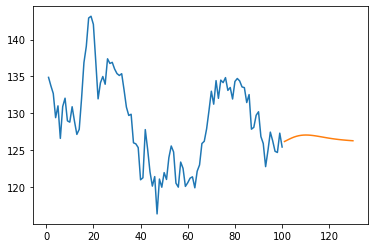

In [96]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

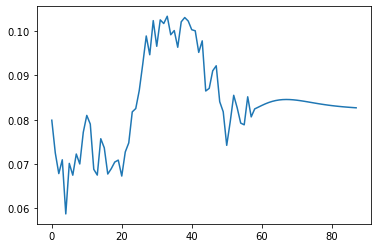

In [97]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [98]:
df3=scaler.inverse_transform(df3).tolist()

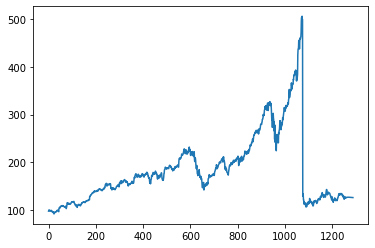

In [99]:
plt.plot(df3)